In [37]:
pip install pytesseract

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [38]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

In [39]:
#image path - C:\Users\skpav\Downloads\AI_DL_Assignments\AI_DL_Assignments\Assignment_5\Screenshot 2025-09-08 134123.png

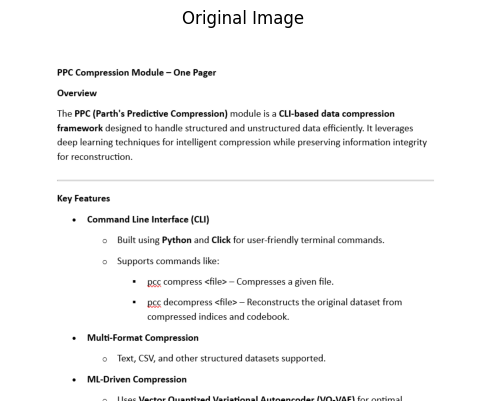

In [40]:
image_path = r'C:\Users\skpav\Downloads\AI_DL_Assignments\AI_DL_Assignments\Assignment_5\Screenshot 2025-09-08 134123.png'
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError('Image not found. Please check the path.')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [41]:
import os
east_model = r'C:\Users\skpav\Downloads\AI_DL_Assignments\AI_DL_Assignments\Assignment_5\frozen_east_text_detection.pb'
print(os.path.exists(east_model))  # Should print True if file exists here


True


In [44]:
east_model = r'C:\Users\skpav\Downloads\AI_DL_Assignments\AI_DL_Assignments\Assignment_5\frozen_east_text_detection.pb'
if not os.path.exists(east_model):
    raise FileNotFoundError(f"EAST model not found at {east_model}. Please download and place it correctly.")

def detect_text_east(image, model_path, conf_threshold=0.5):
    orig = image.copy()
    (H, W) = image.shape[:2]
    newW, newH = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(image, (newW, newH))
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net = cv2.dnn.readNet(model_path)
    net.setInput(blob)
    (scores, geometry) = net.forward(['feature_fusion/Conv_7/Sigmoid',
                                     'feature_fusion/concat_3'])

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        for x in range(0, numCols):
            if scoresData[x] < conf_threshold:
                continue
            offsetX, offsetY = x * 4.0, y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            rects.append((startX, startY, endX, endY))
            confidences.append(float(scoresData[x]))

    # Construct rotated rectangles for NMSBoxesRotated
    if len(rects) > 0:
        rotated_rects = np.array(
            [((r[0] + r[2]) / 2, (r[1] + r[3]) / 2, r[2] - r[0], r[3] - r[1], 0) for r in rects],
            dtype=np.float32
        )
    else:
        rotated_rects = np.zeros((0, 5), dtype=np.float32)

    indices = cv2.dnn.NMSBoxesRotated(rotated_rects, confidences, conf_threshold, 0.4)

    results = []
    if len(indices) > 0:
        for i in indices.flatten():
            (startX, startY, endX, endY) = rects[i]
            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)
            results.append((startX, startY, endX, endY))

    return results

In [25]:
import os
east_model = r'C:\Users\skpav\Downloads\AI_DL_Assignments\AI_DL_Assignments\Assignment_5'
print(os.path.exists(east_model))  # Should print True if path and file exist


True
